# Logo plots showing effects of mutations

## Imports and read data
Import Python modules:

In [1]:
import math
import os

from dms_variants.constants import CBPALETTE

import matplotlib
import matplotlib.pyplot as plt

import numpy

import pandas as pd

from plotnine import *

import yaml

import full_prot_logo  # custom module that uses logomaker to create plots

Get the Uni Sans (all caps) font set up:

In [2]:
font_files = matplotlib.font_manager.findSystemFonts('data/uni-sans')
font_list = matplotlib.font_manager.createFontList(font_files)
matplotlib.font_manager.fontManager.ttflist.extend(font_list)

Set `plotnine` theme:

In [3]:
theme_set(theme_classic())

Read in the configuration file, and then read the input data files from that:

In [4]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)
    
os.makedirs(config['figs_dir'], exist_ok=True)

print(f"Reading single-mutant effects from {config['single_mut_effects_file']}")
mut_effects = pd.read_csv(config['single_mut_effects_file'])
mut_effects.head()

Reading single-mutant effects from results/single_mut_effects/single_mut_effects.csv


,site_RBD,site_SARS2,wildtype,mutant,mutation,mutation_RBD,bind_lib1,bind_lib2,bind_avg,expr_lib1,expr_lib2,expr_avg
0,1,331,N,A,N331A,N1A,-0.05,-0.02,-0.03,-0.14,-0.08,-0.11
1,1,331,N,C,N331C,N1C,-0.08,-0.10,-0.09,-1.56,-0.97,-1.26
2,1,331,N,D,N331D,N1D,0.00,0.07,0.03,-0.75,-0.12,-0.44
3,1,331,N,E,N331E,N1E,0.02,-0.02,0.00,-0.39,-0.24,-0.31
4,1,331,N,F,N331F,N1F,-0.03,-0.16,-0.10,-0.83,-0.57,-0.70


Read annnotations of various properties of sites:

In [5]:
site_annotations = pd.read_csv('data/RBD_sites.csv')

# make sure consistent with site and wildtype data in mut_effects data frame
pd.testing.assert_frame_equal(
        mut_effects[['site_RBD', 'site_SARS2', 'wildtype']].drop_duplicates().reset_index(drop=True),
        site_annotations[['site_RBD', 'site_SARS2', 'amino_acid_SARS2']].rename(columns={'amino_acid_SARS2': 'wildtype'}),
        )

# first few lines
site_annotations.head()

,site_RBD,amino_acid_SARS2,site_SARS2,amino_acid_SARS1,site_SARS1,chain_6M0J,codon_SARS2,amino_acid_RaTG13,amino_acid_GD_Pangolin,RBM,...,SARS1_key_adaptation,epitope_CR3022,epitope_VHH72,epitope_S230,epitope_m396,epitope_F26G19,epitope_80R,epitope_B38,epitope_S309,buried_downRBD
0,1,N,331,N,318.0,NaN,aat,N,N,False,...,False,False,False,False,False,False,False,False,False,True
1,2,I,332,I,319.0,NaN,att,I,I,False,...,False,False,False,False,False,False,False,False,False,True
2,3,T,333,T,320.0,E,aca,T,T,False,...,False,False,False,False,False,False,False,False,False,False
3,4,N,334,N,321.0,E,aac,N,N,False,...,False,False,False,False,False,False,False,False,True,False
4,5,L,335,L,322.0,E,ttg,L,L,False,...,False,False,False,False,False,False,False,False,True,False


## Compute letter heights
Here we explain how we use the experimental measurements to compute letter heights for plotting in the logo plots.

### Letter heights as "probabilities" of observing amino acids
For each site $r$, we first compute the probability $p_{r,a}$ of observing amino acid $a$ under some notion that the probability of observing an amino acid relates to its favorability on expression or ACE2-binding as measured in the experiments.
We compute $p_{r,a}$ over all non-stop amino acids observed at a site, so that $1 = \sum_a p_{r,a}$
Typically there are 20 amino acids observed at a site, although in some cases a few may not be observed.
If an amino acid $a$ is not observed at a site $r$, then we set $p_{r,a} = 0$ under the assumption that non-observed amino acids are generally deleterious (particularly for binding, where the non-observed ones are generally missing because they were eliminated in the pre-sort for expression).

One way to plot the data is to then just make the height of each letter at each site equal to $p_{r,a}$.
In this case, the stacks at all sites sum to one.

### Letter heights as "information content"
After computing the probabilities $p_{r,a}$, we can determine the "information content" at a site, which is how much these probabilities deviate from all being $\frac{1}{20}$ as would occur if there was no constraint at a height (note that there is no need to correct for background amino-acid content as is done for standard information-content sequence logos, as that was done when analyzing the experimental data to get the mutational effects).

The information content $I_r$ at site $r$ is just the total possible entropy if all amino acids were equally probable minus the actual entropy, so $I_r = \ln 20 + \sum_a p_{r,a} \ln p_{r,a}$.

The height of each letter in the information content scheme is then simply the information content times the probability of that amino acid, so $I_r \times p_{r,a}$.
Note that these letter heights are analogous to those in classic sequence logos used to show transcription-factor binding motifs.

### Computing probabilities from experimental measurements
For each site $r$ and amino-acid $a$, we have an experimental measurement of ACE2-binding or expression.
We will denote these measurements as $x_{r,a}$, using $x_{r,a}^{\rm{bind}}$ or $x_{r,a}^{
\rm{express}}$ when we need to distinguish measurements on ACE2-binding from measurements on RBD expression.

These measurements are all expressed as differences in the log measured value of the mutant relative to the wildtype.
Specifically, for ACE2-binding the measurements are $x_{r,a}^{\rm{bind}} = \log_{10} K_{A,\rm{app}}^{r,a} - \log_{10} K_{A,\rm{app}}^{\rm{wt}}$ where $K_{A,\rm{app}}^{r,a}$ is the apparent assocation constant for binding to ACE2 of the variant with amino-acid $a$ at site $r$, and $K_{A,\rm{app}}^{\rm{wt}}$ is the same assocation constant for wildtype.
For expression, the measurements are $x_{r,a}^{\rm{expr}} = \ln E_{r,a} - \ln E_{\rm{wt}}$ where $E_{r,a}$ is the flow cytometry measured expression for the variant with amino-acid $a$ at site $r$ and $E_{\rm{wt}}$ is the same measurement for wildtype.
So by definition, $x_{r,a} = 0$ when $a$ is equal to the wildtype amino acid at site $r$.

It therefore follows that if we want to compute the "probability" of observing each amino acid at a site under the idea that the probability is proportional to the measured value for that amino acid, we have $p_{r,a} = \frac{\exp\left(\alpha x_{r,a} \right)}{\sum_{a'}\exp\left(\alpha x_{r,a'} \right)}$ where $\alpha > 0$ is a constant.
Larger values of $\alpha$ make the $p_{r,a}$ values more strongly peaked on amino acids with more favorable measurements.

What is the "correct" choice for $\alpha$?
If we interpret the binding probabilities in a thermodynamic perspective, then the value of $\alpha$ should depend on two things: the choice of base when taking the log of the experimental measurement, and the temperature for which we want to compute the probabilities relative to the temperature at which the experimental measurements were made.
In particular, in a thermodynamic perspective, we should have $\alpha = \left(\ln b\right) \times \frac{T_{\rm{experiment}}}{T}$ where $b$ is the base used when taking the log of the experimental measurements, $T$ is the temperature at which we want to compute the probabilities, and $T_{\rm{experiment}}$ is the temperature at which the experiments were performed (where temperatures are in absolute units, e.g. Kelvin).
Assuming that we want to compute probabilities at the same temperature at which we performed the experiments (room temperature), then this gives values of $\alpha_{\rm{bind}} = \ln 10$ (basically correcting for the use of log base-10 when processing experimental data).

There is no natural thermodynamic interpretation for expression, so we arbitrarily choose $\alpha_{\rm{expr}}$ so that the range of the exponents in computing $p_{r,a}^{\rm{expr}}$ is the same as that for computing $p_{r,a}^{\rm{bind}}$, which gives $\alpha_{\rm{expr}} = \alpha_{\rm{bind}} \frac{\max x_{r,a}^{\rm{expr}} - \min x_{r,a}^{\rm{expr}}}{\max x_{r,a}^{\rm{bind}} - \min x_{r,a}^{\rm{bind}}}$.

Note, however, since in the end we are creating visualizations, it would also be reasonable to manually tune the values of $\alpha$ to adjust how much more favorable amino acids have larger letters (on a heat-map representation, this adjustment of $\alpha$ just corresponds to changing the log base or the color scale).
So the the actual calculatins below, we add a manual scaling factor to make things look a bit more peaked than in the thermodynamic interpretation:

### Actually compute letter heights
We now actually compute the letter heights use the definitions above.
In the final data frame, `prob_bind` / `prob_expr` are the letter heights defined by $p_{r,a}$ above, and `mut_info_bind` / `mut_info_expr` are the letter heights defined by $I_r \times p_{r,a}$.

In [6]:
# get mutation effects without stop codons
nostop_mut_effects = mut_effects.query('(mutant != "*") and (wildtype != "*")')

# exponent scaling factors alpha for binding and expression
manual_scale_alpha = 1.3  # ad hoc additional scaling factor for exponents
alpha_bind = math.log(10) * manual_scale_alpha
alpha_expr = alpha_bind * ((nostop_mut_effects['expr_avg'].max() - nostop_mut_effects['expr_avg'].min()) /
                           (nostop_mut_effects['bind_avg'].max() - nostop_mut_effects['bind_avg'].min()))
print(f"alpha (exponent scale factor):\nbinding = {alpha_bind:.3f}\nexpression = {alpha_expr:.3f}")

def compute_site_info(p):
    p = p[p > 0]
    assert len(p), 'no non-zero values'
    return math.log(20) + sum(p * numpy.log(p))

letter_heights = (
    nostop_mut_effects
    .assign(nonorm_prob_bind=lambda x: numpy.exp(alpha_bind * x['bind_avg']).fillna(0),
            nonorm_prob_expr=lambda x: numpy.exp(alpha_expr * x['expr_avg']).fillna(0),
            sitesum_prob_bind=lambda x: x.groupby('site_RBD')['nonorm_prob_bind'].transform('sum'),
            sitesum_prob_expr=lambda x: x.groupby('site_RBD')['nonorm_prob_expr'].transform('sum'),
            prob_bind=lambda x: x['nonorm_prob_bind'] / x['sitesum_prob_bind'],
            prob_expr=lambda x: x['nonorm_prob_expr'] / x['sitesum_prob_expr'],
            site_info_bind=lambda x: x.groupby('site_RBD')['prob_bind'].transform(compute_site_info),
            site_info_expr=lambda x: x.groupby('site_RBD')['prob_expr'].transform(compute_site_info),
            mut_info_bind=lambda x: x['prob_bind'] * x['site_info_bind'],
            mut_info_expr=lambda x: x['prob_expr'] * x['site_info_expr'],
            )
    [['site_SARS2', 'site_RBD', 'wildtype', 'mutant',
      'prob_bind', 'prob_expr', 'site_info_bind', 'site_info_expr',
      'mut_info_bind', 'mut_info_expr']]
    )

assert not letter_heights[['mut_info_bind', 'mut_info_expr', 'prob_bind', 'prob_expr']].isnull().any(axis=None)

letter_heights.head().round(3)

alpha (exponent scale factor):
binding = 2.993
expression = 2.947


,site_SARS2,site_RBD,wildtype,mutant,prob_bind,prob_expr,site_info_bind,site_info_expr,mut_info_bind,mut_info_expr
0,331,1,N,A,0.050,0.119,0.009,0.32,0.000,0.038
1,331,1,N,C,0.042,0.004,0.009,0.32,0.000,0.001
2,331,1,N,D,0.060,0.045,0.009,0.32,0.001,0.014
3,331,1,N,E,0.055,0.066,0.009,0.32,0.001,0.021
4,331,1,N,F,0.041,0.021,0.009,0.32,0.000,0.007


As a quick sanity check, plot the site information content $I_r$ for binding and expression at each site:

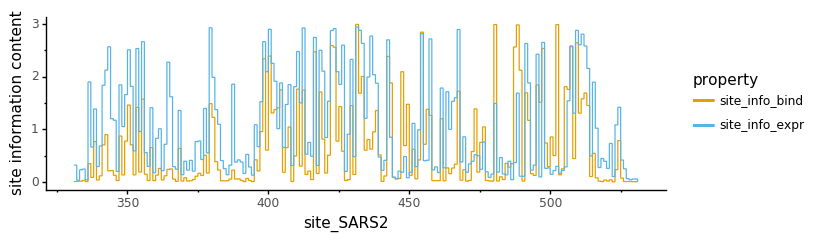

In [7]:
p = (ggplot(letter_heights.melt(id_vars='site_SARS2',
                                value_vars=['site_info_bind', 'site_info_expr'],
                                value_name='site information content',
                                var_name='property')
            ) +
     aes('site_SARS2', 'site information content', color='property') +
     geom_step() +
     theme(figure_size=(8, 2.25)) +
     scale_color_manual(values=CBPALETTE[1: ])
     )

_ = p.draw()

## Draw logo plots

### Define coloring and highlighting scheme
First combine letter heights with key site annotations:

In [8]:
logo_df = (
    letter_heights
    .merge(site_annotations[['site_SARS2', 'amino_acid_SARS1', 'RSA_bound', 'RSA_unbound', 'SARS2_ACE2_contact']],
           on='site_SARS2',
           validate='many_to_one')
    )

logo_df.head()

,site_SARS2,site_RBD,wildtype,mutant,prob_bind,prob_expr,site_info_bind,site_info_expr,mut_info_bind,mut_info_expr,amino_acid_SARS1,RSA_bound,RSA_unbound,SARS2_ACE2_contact
0,331,1,N,A,0.050044,0.119161,0.009328,0.32016,0.000467,0.038151,N,NaN,NaN,False
1,331,1,N,C,0.041817,0.004022,0.009328,0.32016,0.000390,0.001288,N,NaN,NaN,False
2,331,1,N,D,0.059890,0.045062,0.009328,0.32016,0.000559,0.014427,N,NaN,NaN,False
3,331,1,N,E,0.054746,0.066097,0.009328,0.32016,0.000511,0.021162,N,NaN,NaN,False
4,331,1,N,F,0.040584,0.020945,0.009328,0.32016,0.000379,0.006706,N,NaN,NaN,False


Now assign colors. 

We color amino acid letters:
 - dark blue if wildtype in SARS-CoV-2
 - green if wildtype in SARS-CoV-1 (but not SARS-CoV-2)
 - gray otherwise.
 
We highlight sites as follows (always using an alpha transparency of 0.25):
 - yellow if an ACE2 contact site in SARS-CoV-2 structure

In [9]:
def assign_color(row):
    if row['wildtype'] == row['mutant']:
        return CBPALETTE[5]
    elif row['mutant'] == row['amino_acid_SARS1']:
        return CBPALETTE[3]
    else:
        return CBPALETTE[0]
    
def assign_highlight_color(row):
    if row['SARS2_ACE2_contact'] is True:
        return CBPALETTE[4]
    else:
        return None
    
logo_df = (
    logo_df
    .assign(color=lambda x: x.apply(assign_color, axis=1),
            highlight_color=lambda x: x.apply(assign_highlight_color, axis=1),
            highlight_alpha=0.2,
            )
    )

### Draw logos for binding and expression separately
First we draw logo plots that show the amino acids preferred for binding and expression separately in either the probability or information-content representation:


Plotting prob_bind and saving to results/figures/prob_bind_logo.pdf...


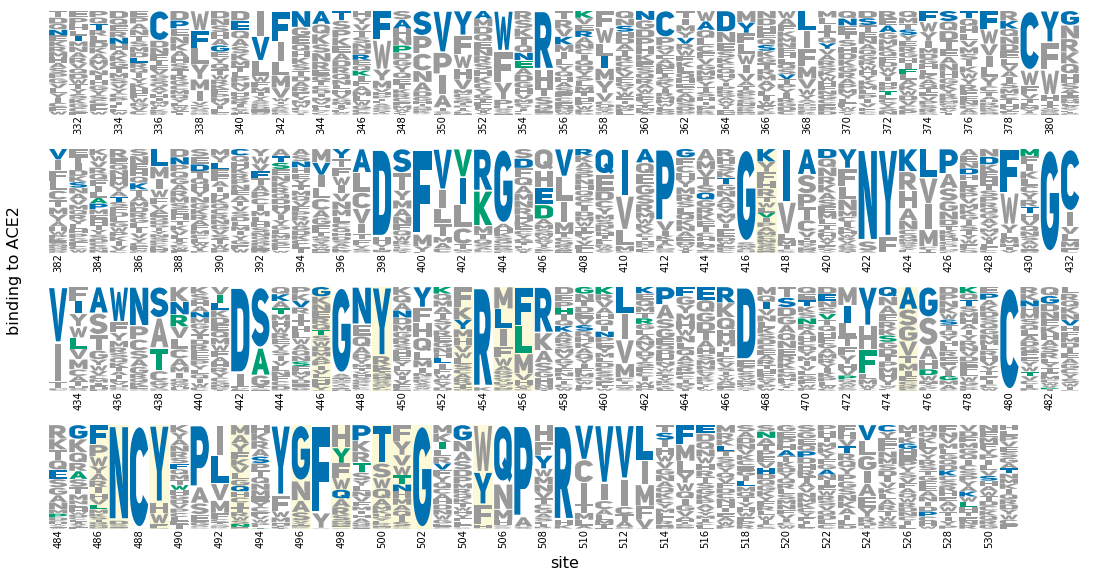


Plotting prob_expr and saving to results/figures/prob_expr_logo.pdf...


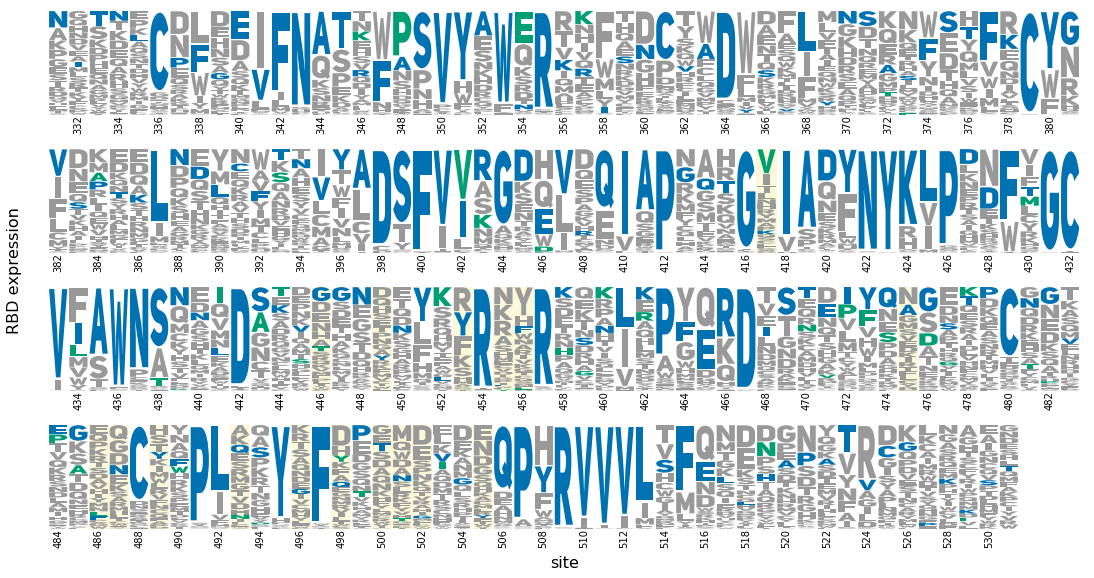

In [10]:
for height_col, ylabel in [
        ('prob_bind', 'binding to ACE2'),
        ('prob_expr', 'RBD expression'),
        ]:

    filename = os.path.join(config['figs_dir'], f"{height_col}_logo.pdf")
    print(f"\nPlotting {height_col} and saving to {filename}...")
    
    fig = full_prot_logo.full_prot_logo(
        logo_df,
        site_col='site_SARS2',
        letter_col='mutant',
        height_col=height_col,
        color_col='color',
        highlight_color_col='highlight_color',
        highlight_alpha_col='highlight_alpha',
        missing_letter='zero_height',
        sites_per_line=51,
        scaleheight=1.2,
        style_xticks_kwargs={'spacing': 2,  # number every other residue  
                             },
        logo_kwargs={'font_name': 'Uni Sans',
                     'width': 0.9,  # width of letters
                     'vpad': 0.05,  # vertical padding between letters
                     'stack_order': 'big_on_top',
                     },
        xlabel='site',
        ylabel=ylabel,
        )
    
    display(fig)
    fig.savefig(filename)
    plt.close(fig)

### Draw combined logo with binding and expression
We draw logos that show **both** binding and expression data on the same plot, with binding as capital letters above the line and binding as lower-case letters below the center line.

First, make a data frame suitable for this by concatenating the logo data frame, mutating the letters for binding to be lower case and re-naming columns to no longer specify binding versus expression:

In [11]:
combo_logo_df = pd.concat([
        # data for binding
        logo_df.drop(columns=[c for c in logo_df.columns if '_expr' in c])
               .rename(columns={c: c.replace('_bind', '') for c in logo_df.columns})
               .assign(property_type='binding'),
        # data for expression, make lowercase letters and negative heights
        logo_df.drop(columns=[c for c in logo_df.columns if '_bind' in c])
               .rename(columns={c: c.replace('_expr', '') for c in logo_df.columns})
               .assign(mutant=lambda x: x['mutant'].str.lower(),
                       prob=lambda x: -x['prob'],
                       mut_info=lambda x: -x['mut_info'],
                       property_type='expression'),
        ],
        ignore_index=True, sort=False)

combo_logo_df

,site_SARS2,site_RBD,wildtype,mutant,prob,site_info,mut_info,amino_acid_SARS1,RSA_bound,RSA_unbound,SARS2_ACE2_contact,color,highlight_color,highlight_alpha,property_type
0,331,1,N,A,0.050044,0.009328,0.000467,N,NaN,NaN,False,#999999,None,0.2,binding
1,331,1,N,C,0.041817,0.009328,0.000390,N,NaN,NaN,False,#999999,None,0.2,binding
2,331,1,N,D,0.059890,0.009328,0.000559,N,NaN,NaN,False,#999999,None,0.2,binding
3,331,1,N,E,0.054746,0.009328,0.000511,N,NaN,NaN,False,#999999,None,0.2,binding
4,331,1,N,F,0.040584,0.009328,0.000379,N,NaN,NaN,False,#999999,None,0.2,binding
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8035,531,201,T,s,-0.054149,0.007288,-0.000395,T,NaN,NaN,False,#999999,None,0.2,expression
8036,531,201,T,t,-0.051050,0.007288,-0.000372,T,NaN,NaN,False,#0072B2,None,0.2,expression
8037,531,201,T,v,-0.042777,0.007288,-0.000312,T,NaN,NaN,False,#999999,None,0.2,expression
8038,531,201,T,w,-0.040329,0.007288,-0.000294,T,NaN,NaN,False,#999999,None,0.2,expression


Now draw these logo plots with binding (upper-case letters) at top and expression (lower-case letters) at bottom:


Plotting prob and saving to results/figures/prob_logo.pdf...


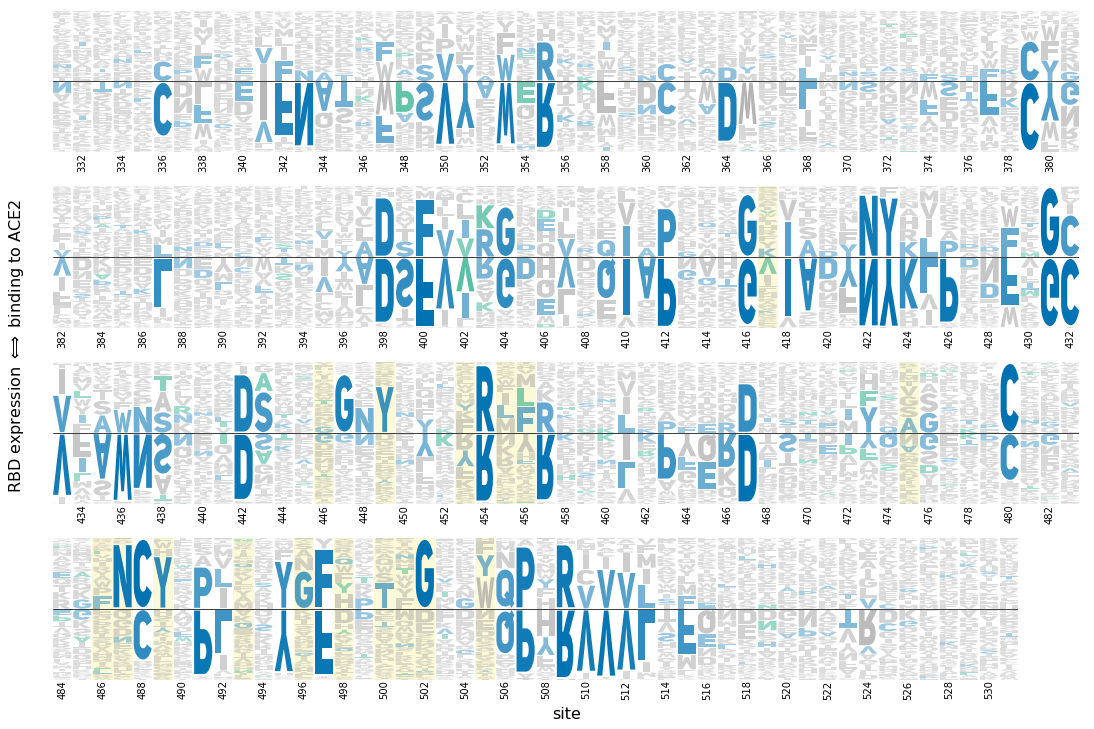

In [12]:
for height_col in ['prob']:

    filename = os.path.join(config['figs_dir'], f"{height_col}_logo.pdf")
    print(f"\nPlotting {height_col} and saving to {filename}...")
    
    fig = full_prot_logo.full_prot_logo(
        combo_logo_df,
        site_col='site_SARS2',
        letter_col='mutant',
        height_col=height_col,
        color_col='color',
        highlight_color_col='highlight_color',
        highlight_alpha_col='highlight_alpha',
        missing_letter='zero_height',
        sites_per_line=51,
        scaleheight=1.5,
        fade_letters_by_height=(0.3, 1),
        style_xticks_kwargs={'spacing': 2,  # number every other residue  
                             },
        logo_kwargs={'font_name': 'Uni Sans',
                     'width': 0.9,  # width of letters
                     'vpad': 0.05,  # vertical padding between letters
                     'flip_below': True,  # flip letters below line
                     'stack_order': 'small_on_top',  # small letters closer to baseline
                     },
        xlabel='site',
        ylabel='RBD expression $\Longleftrightarrow$ binding to ACE2',
        all_letters=combo_logo_df['mutant'].unique()
        )
    
    display(fig)
    fig.savefig(filename)
    plt.close(fig)